# Author: Lucas Ratajczyk

I found a side-by-side clear and blurry picture and used MATLAB to convert it into two separate image matrices, Clear.mat and Blurry.mat

Step 1 is to read in these matrices and the associated blurring matrix

In [107]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

X_true = np.array(loadmat('Clear.mat')['ClearPic'])
B_orig = np.array(loadmat('Blurry.mat')['BlurryPic'])
PSF = np.array(loadmat('PSF.mat')['PSF'])

This blurry image was produced only by applying the PSF (Point Spread Function) to the clear image in X_true. In reality, there will also be some independent noise which is added to the blurry image so that is what we do below after showing you what the image looks like with only the blurring function.

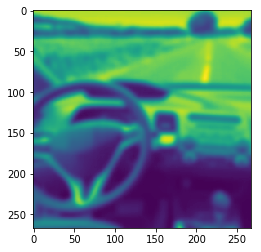

In [108]:
# Before adding the independent noise, let's first take a look at what the blurry image looks like without noise
plt.imshow(B_orig)

In [109]:
# Here we define the noise function which will add light/dark specs to the image randomly.
def noise(image,probability,rgb):
    output = np.zeros(image.shape)
    thres = 1 - probability
    if(rgb == True):
        for i in range(image.shape[0]): # Each Pixel X
            for j in range(image.shape[1]): # Each Pixel Y
                for k in range(image.shape[2]): #Each of the 3 color values (R,G,B)
                    rdn = random.random() 
                    if rdn < probability:
                        output[i][j][k] = 0.0 # Empty, no color on that value, if rgb for this pixel is 0,0,0 color is White
                    elif rdn > thres:
                        output[i][j][k] = 1.0 # Highest value a color value can take, if rgb for this pixel are all 1, color is Black
                    else:
                        output[i][j][k] = image[i][j][k] # copy original's pixel r,g,b if probability not met
    else:
        for i in range(image.shape[0]): # Each Pixel X
            for j in range(image.shape[1]): # Each Pixel Y
                rdn = random.random() 
                if rdn < probability:
                    output[i][j] = 0.0 # Empty, no color on that value, if rgb for this pixel is 0,0,0 color is White
                elif rdn > thres:
                    output[i][j] = 1.0 # Highest value a color value can take, if rgb for this pixel are all 1, color is Black
                else:
                    output[i][j] = image[i][j] # copy original's pixel if probability not met
    return output

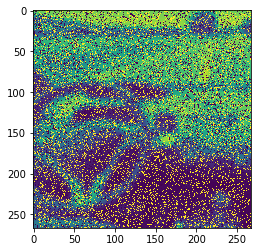

In [110]:
# Now that we've defined the function to add the independent noise, we add some to our blurry image and display it
B = noise(B_orig,0.15, False)
plt.imshow(B)

In theory, it is absolutely possible to get the clear image from the original blurry one just using the PSF like we show below. However, the addition of the independant noise greatly corrupts this result.

When no independent noise is present, the clear image can be extracted easily using only the PSF


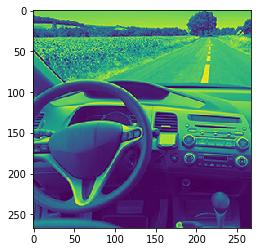

In [111]:
# To get the clear image just using the original B (without independent noise), we simply solve the equation B_orig = PSF@X
# This results in X = PSF_inverse@B_orig
PSF_inverse = np.linalg.inv(PSF)
X = PSF_inverse@B_orig
plt.imshow(X)
print('When no independent noise is present, the clear image can be extracted easily using only the PSF')

Once independent noise is introduced, the result of this method becomes much worse


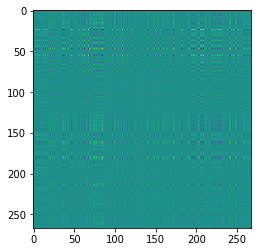

In [112]:
# Now let's try the same procedure using B instead of B_orig (use the version with independent noise)
X = PSF_inverse@B
plt.imshow(X)
print('Once independent noise is introduced, the result of this method becomes much worse')

To address the inaccuracy introduced by the independent noise, we use L1-norm regularization (LASSO). Since LASSO doesn't allow for a closed for solution (it isn't differentiable), we must use gradient descent to find the optimum solution.

In [113]:
b = np.reshape(B, B.shape[0]*B.shape[1])
psf = np.reshape(PSF, PSF.shape[0]*PSF.shape[1])

In [114]:
# First, we choose a starting X (for simplicity, we chose to start with X = B), a step size, a regularization weight,
# and a maximum number of iterations allowed
step = 0.01
lam = 1
max_iter = 20

# We then set up some variables to hold our intermediate results for Z (gradient descent step results)
# and W (regularization step results)
z = np.zeros((b.shape[0], max_iter))
w = np.zeros((b.shape[0], max_iter+1))
w[:,0] = b

# For each iteration until we reach the maximum,
for i in range(max_iter):
    
    # LS Gradient Descent
    z[:,i] = w[:,i] - step*psf.T@(psf@w[:,i] - b)
    
    # L1-Norm Regularization
    w[:,i+1] = z[:,i] - lam*step/2
    for j in range(w[:,i+1].shape[0]):
        if w[j,i+1] < 0:
            w[j,i+1] = z[j,i] + lam*step/2
    
    # Check for convergence and exit the loop if converged (average difference between the previous and current W is
    # less than 0.01)
    if np.mean(abs(w[:,i] - w[:,i+1])) < 0.01:
        break

Now let's plot the image that results from the final iteration of the above code block

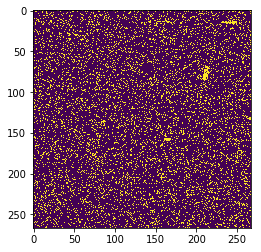

In [105]:
X = np.reshape(w[:,4], (B.shape[0], B.shape[1]))
plt.imshow(X)

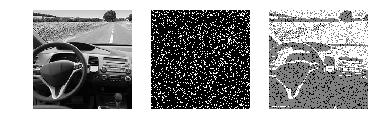

In [106]:
E = X_true - X

fig = plt.figure()

ax = fig.add_subplot(131)
ax.imshow(X_true, cmap='gray')
ax.set_axis_off()

ax = fig.add_subplot(132)
ax.imshow(X, cmap='gray')
ax.set_axis_off()

ax = fig.add_subplot(133)
ax.imshow(E, cmap='gray')
ax.set_axis_off()
plt.show()